# **Setup (CPU)**

(Run all)

In [ ]:
!cat /proc/cpuinfo
#prep
%tensorflow_version 1.x
import os
!pip install tqdm -q
from tqdm.notebook import tqdm
from IPython.display import clear_output
from os.path import exists, join, basename, splitext
!pip install gdown --upgrade resampy
git_repo_url = 'https://github.com/SortAnon/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
# clone and install
  !git clone -q --recursive {git_repo_url}
  !git clone -q --recursive https://github.com/SortAnon/hifi-gan
  !pip install -q librosa unidecode
import sys
sys.path.append('hifi-gan')
sys.path.append(project_name)

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
#wrire the denoiser
%%writefile /content/hifi-gan/denoiser.py
import sys
import torch
from stft import STFT


class Denoiser(torch.nn.Module):
    """ WaveGlow denoiser, adapted for HiFi-GAN """

    def __init__(
        self, hifigan, filter_length=1024, n_overlap=4, win_length=1024, mode="zeros"
    ):
        super(Denoiser, self).__init__()
        self.stft = STFT(
            filter_length=filter_length,
            hop_length=int(filter_length / n_overlap),
            win_length=win_length,
        )
        if mode == "zeros":
            mel_input = torch.zeros((1, 80, 88))
        elif mode == "normal":
            mel_input = torch.randn((1, 80, 88))
        else:
            raise Exception("Mode {} if not supported".format(mode))

        with torch.no_grad():
            bias_audio = hifigan(mel_input).view(1, -1).float()
            bias_spec, _ = self.stft.transform(bias_audio)

        self.register_buffer("bias_spec", bias_spec[:, :, 0][:, :, None])

    def forward(self, audio, strength=0.1):
        audio_spec, audio_angles = self.stft.transform(audio.float())
        audio_spec_denoised = audio_spec - self.bias_spec * strength
        audio_spec_denoised = torch.clamp(audio_spec_denoised, 0.0)
        audio_denoised = self.stft.inverse(audio_spec_denoised, audio_angles)
        return audio_denoised

Overwriting /content/hifi-gan/denoiser.py


# **Inference**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Input Files
!pip install SpeechRecognition
!pip install pydub
!pip install translate

    
# importing libraries
import speech_recognition as sr
import os
from pydub import AudioSegment

# importing libraries
import speech_recognition as sr
from pydub.silence import split_on_silence
from translate import Translator

# create a speech recognition object
r = sr.Recognizer()

# a function that splits the audio file into chunks
# and applies speech recognition
transcript = []


def get_large_audio_transcription(path):
    """
    Splitting the large audio file into chunks
    and apply speech recognition on each of these chunks
    """
    # open the audio file using pydub
    sound = AudioSegment.from_wav(path)
    # split audio sound where silence is 200 miliseconds or more and get chunks
    chunks = split_on_silence(sound,
                              min_silence_len=100,
                              silence_thresh=sound.dBFS-14,
                              keep_silence=500,
                              )
    folder_name = "wavs"
    # create a directory to store the audio chunks
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    whole_text = ""
    # process each chunk
    for i, audio_chunk in enumerate(chunks, start=1):
        # export audio chunk and save it in
        # the `folder_name` directory.
        chunk_filename = os.path.join(folder_name, f"{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # recognize the chunk
        with sr.AudioFile(chunk_filename) as source:
            audio_listened = r.record(source)
            # try converting it to text
            try:
                text = r.recognize_google(audio_listened)
            except sr.UnknownValueError as e:
                pass
            else:
                text = f"{text.capitalize()}. "
                with open('textfile.txt', 'w') as f:
                    for _ in transcript:
                        f.write(whole_text)
                transcript.append(text)
                whole_text += text + '\n'
    # return the text for all chunks detected
    return whole_text


get_large_audio_transcription(
    '/content/drive/MyDrive/fn.wav')

translated_text = []

language = input("Enter the language to translate to: ")

if language == 'fr':
    translate_text_french = Translator(from_lang='en', to_lang='fr')
    for i in transcript:
        translated_text.append(translate_text_french.translate(i))

    with open('translated_textfile.txt', 'w') as f:
        for i in translated_text:
            f.write(i + '\n')

elif language == 'es':
    translate_text_spanish = Translator(from_lang='en', to_lang='es')
    for i in transcript:
        translated_text.append(translate_text_spanish.translate(i))

    with open('translated_textfile.txt', 'w') as f:
        for i in translated_text:
            f.write(i + '\n')
else:
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enter the language to translate to: es


Using universal Hifi-Gan model.
Current Config:
pronounciation_dictionary: True
show_graphs: True
max_duration (in seconds): 20
stop_threshold: 0.5
superres_strength: 4.0


Enter/Paste your text.
--------------------------------------------------


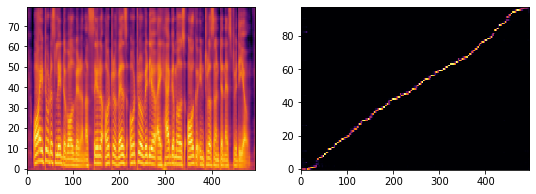

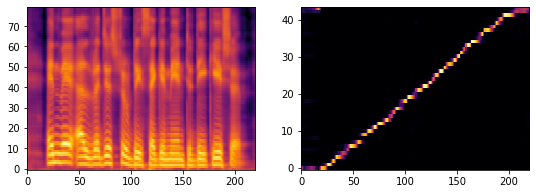

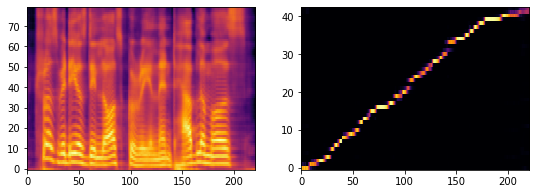

max value is  tensor(1.0042)



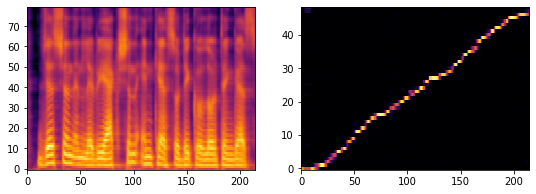

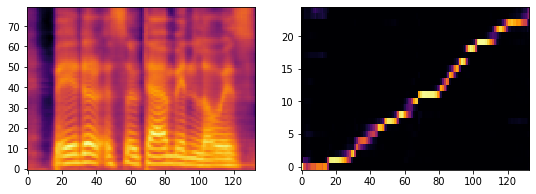

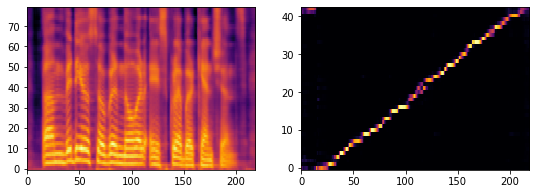

max value is  tensor(1.0015)



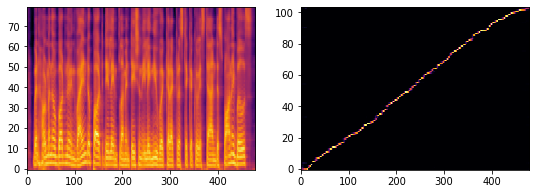

max value is  tensor(1.0015)



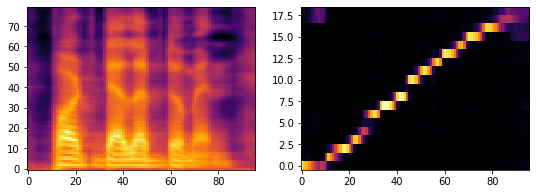

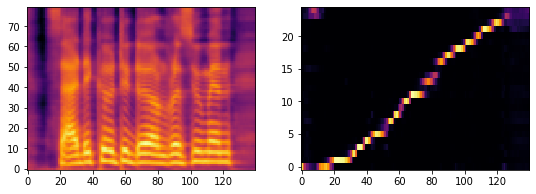

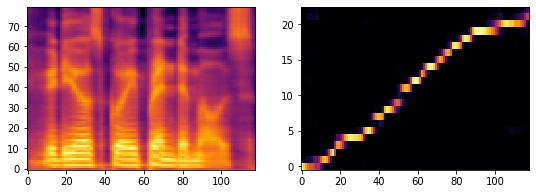

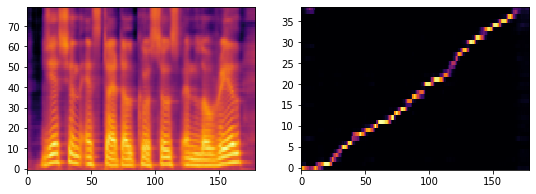

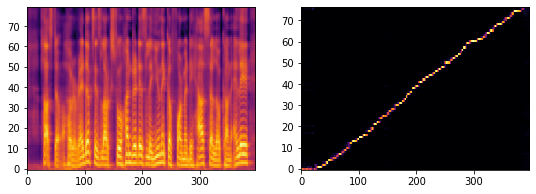

max value is  tensor(1.0002)



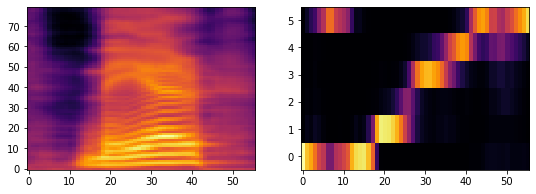

In [ ]:
#Universal HiFi-GAN (has some robotic noise): 1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW


tacotron_id = "1YrS2C5z6Gky8IfX-Yj0cIBUS_KWyuKWw" #@param {type:"string"}

hifigan_id = "universal" #@param {type:"string"}

#@markdown _leave blank or enter "universal" for universal model_

#@markdown ---

if tacotron_id != "":
    TACOTRON2_ID = tacotron_id
else:
    raise Exception("No ID provided.")

if hifigan_id in {"", "universal"}:
    HIFIGAN_ID = "universal"
    print("Using universal Hifi-Gan model.")
else:
    HIFIGAN_ID = hifigan_id

# Check if Initialized
try:
    initialized
except NameError:
    print("Setting up, please wait.\n")
    with tqdm(total=5, leave=False) as pbar:
        
        import time
        import matplotlib
        import matplotlib.pylab as plt
        import gdown
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from hparams import create_hparams
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import mel_spectrogram, MAX_WAV_VALUE
        from models import Generator
        from denoiser import Denoiser
        import resampy
        import scipy.signal

        pbar.update(1) # initialized Dependancies

        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        # Setup Pronounciation Dictionary
        !wget 'https://github.com/justinjohn0306/tacotron2/releases/download/assets/merged.dict.txt'
        thisdict = {}
        for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1) # Downloaded and Set up Pronounciation Dictionary

        def ARPA(text, punctuation=r"!?,.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID, conf_name):
            # Download HiFi-GAN
            hifigan_pretrained_model = 'hifimodel_' + conf_name
            #gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)

            if MODEL_ID == 1:
              !wget "https://github.com/justinjohn0306/tacotron2/releases/download/assets/Superres_Twilight_33000" -O $hifigan_pretrained_model
            elif MODEL_ID == "universal":
              !wget "https://github.com/justinjohn0306/tacotron2/releases/download/assets/g_02500000" -O $hifigan_pretrained_model
            else:
              gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)

            if not exists(hifigan_pretrained_model):
                raise Exception("HiFI-GAN model failed to download!")

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", conf_name + ".json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device("cpu"))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cpu"))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            denoiser = Denoiser(hifigan, mode="normal")
            return hifigan, h, denoiser

        # Download character HiFi-GAN
        hifigan, h, denoiser = get_hifigan(HIFIGAN_ID, "config_v1")
        # Download super-resolution HiFi-GAN
        hifigan_sr, h2, denoiser_sr = get_hifigan(1, "config_32k")
        pbar.update(1) # Downloaded and Set up HiFi-GAN

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):
            # Download Tacotron2
            tacotron2_pretrained_model = 'MLPTTS'
            gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")
            # Load Tacotron2 and Config
            hparams = create_hparams()
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 3000 # Max Duration
            hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
            model = Tacotron2(hparams)
            state_dict = torch.load(tacotron2_pretrained_model, map_location=torch.device("cpu"))['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.eval()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

        # Extra Info
        def end_to_end_infer(text, pronounciation_dictionary, show_graphs):
            for i in [x for x in text.split("\n") if len(x)]:
                if not pronounciation_dictionary:
                    if i[-1] != ";": i=i+";" 
                else: i = ARPA(i)
                with torch.no_grad(): # save VRAM by not including gradients
                    sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
                    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
                    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
                    if show_graphs:
                        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                                alignments.float().data.cpu().numpy()[0].T))
                    y_g_hat = hifigan(mel_outputs_postnet.float())
                    audio = y_g_hat.squeeze()
                    audio = audio * MAX_WAV_VALUE
                    audio_denoised = denoiser(audio.view(1, -1), strength=35)[:, 0]

                    # Resample to 32k
                    audio_denoised = audio_denoised.cpu().numpy().reshape(-1)

                    normalize = (MAX_WAV_VALUE / np.max(np.abs(audio_denoised))) ** 0.9
                    audio_denoised = audio_denoised * normalize
                    wave = resampy.resample(
                        audio_denoised,
                        h.sampling_rate,
                        h2.sampling_rate,
                        filter="sinc_window",
                        window=scipy.signal.windows.hann,
                        num_zeros=8,
                    )
                    wave_out = wave.astype(np.int16)

                    # HiFi-GAN super-resolution
                    wave = wave / MAX_WAV_VALUE
                    wave = torch.FloatTensor(wave).to(torch.device("cpu"))
                    new_mel = mel_spectrogram(
                        wave.unsqueeze(0),
                        h2.n_fft,
                        h2.num_mels,
                        h2.sampling_rate,
                        h2.hop_size,
                        h2.win_size,
                        h2.fmin,
                        h2.fmax,
                    )
                    y_g_hat2 = hifigan_sr(new_mel)
                    audio2 = y_g_hat2.squeeze()
                    audio2 = audio2 * MAX_WAV_VALUE
                    audio2_denoised = denoiser(audio2.view(1, -1), strength=35)[:, 0]

                    # High-pass filter, mixing and denormalizing
                    audio2_denoised = audio2_denoised.cpu().numpy().reshape(-1)
                    b = scipy.signal.firwin(
                        101, cutoff=10500, fs=h2.sampling_rate, pass_zero=False
                    )
                    y = scipy.signal.lfilter(b, [1.0], audio2_denoised)
                    y *= superres_strength
                    y_out = y.astype(np.int16)
                    y_padded = np.zeros(wave_out.shape)
                    y_padded[: y_out.shape[0]] = y_out
                    sr_mix = wave_out + y_padded
                    sr_mix = sr_mix / normalize
                    

                    print("")
                    ipd.display(ipd.Audio(sr_mix.astype(np.int16), rate=h2.sampling_rate))
    from IPython.display import clear_output
    clear_output()
    initialized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h, denoiser = get_hifigan(HIFIGAN_ID, "config_v1")
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = True #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = True #@param {type:"boolean"}
max_duration =  20#@param {type:"integer"}
model.decoder.max_decoder_steps = max_duration * 80
stop_threshold = 0.5
model.decoder.gate_threshold = stop_threshold
superres_strength = 4.0

print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\nsuperres_strength: {superres_strength}\n\n")

time.sleep(1)
print("Enter/Paste your text.")
contents = []
print("-"*50)
for i in translated_text:
  line = i
  end_to_end_infer(line, not pronounciation_dictionary, show_graphs)
  # os.mkdir('Aud_files')
  # shutil.move(, 'Aud_files')
